# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, np.array([1]))

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [34]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), np.array([1]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x,  np.array([1])), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [35]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
# print(target_index)
# print(predictions)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [38]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [40]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [53]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.398349
Epoch 1, loss: 2.330618
Epoch 2, loss: 2.310400
Epoch 3, loss: 2.304444
Epoch 4, loss: 2.302615
Epoch 5, loss: 2.302094
Epoch 6, loss: 2.301873
Epoch 7, loss: 2.302202
Epoch 8, loss: 2.301848
Epoch 9, loss: 2.302173


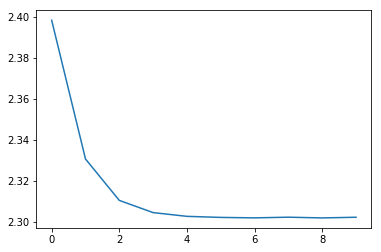

In [54]:
# let's look at the loss history!
plt.plot(loss_history)

In [56]:
train_y

array([9, 9, 2, ..., 4, 2, 7], dtype=uint8)

In [59]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.146
Epoch 0, loss: 2.302423
Epoch 1, loss: 2.302083
Epoch 2, loss: 2.301670
Epoch 3, loss: 2.302081
Epoch 4, loss: 2.302290
Epoch 5, loss: 2.302151
Epoch 6, loss: 2.302414
Epoch 7, loss: 2.301578
Epoch 8, loss: 2.301524
Epoch 9, loss: 2.303614
Epoch 10, loss: 2.302318
Epoch 11, loss: 2.300880
Epoch 12, loss: 2.303031
Epoch 13, loss: 2.302595
Epoch 14, loss: 2.302180
Epoch 15, loss: 2.301739
Epoch 16, loss: 2.302451
Epoch 17, loss: 2.301505
Epoch 18, loss: 2.301952
Epoch 19, loss: 2.302135
Epoch 20, loss: 2.302436
Epoch 21, loss: 2.301901
Epoch 22, loss: 2.303091
Epoch 23, loss: 2.302026
Epoch 24, loss: 2.301581
Epoch 25, loss: 2.301885
Epoch 26, loss: 2.302856
Epoch 27, loss: 2.302123
Epoch 28, loss: 2.301570
Epoch 29, loss: 2.301555
Epoch 30, loss: 2.301822
Epoch 31, loss: 2.302584
Epoch 32, loss: 2.303070
Epoch 33, loss: 2.301872
Epoch 34, loss: 2.303081
Epoch 35, loss: 2.302455
Epoch 36, loss: 2.302097
Epoch 37, loss: 2.301613
Epoch 38, loss: 2.302004
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [70]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
reg_strengths = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print('learning rate =', lr, 'reg =', rs, 'accuracy =', accuracy)
        if best_val_accuracy is None:
            best_val_accuracy = accuracy
            best_classifier = classifier
        if accuracy>best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.304403
Epoch 1, loss: 2.302043
Epoch 2, loss: 2.302137
Epoch 3, loss: 2.303779
Epoch 4, loss: 2.303087
Epoch 5, loss: 2.304882
Epoch 6, loss: 2.304572
Epoch 7, loss: 2.301778
Epoch 8, loss: 2.303566
Epoch 9, loss: 2.302873
Epoch 10, loss: 2.303241
Epoch 11, loss: 2.303136
Epoch 12, loss: 2.301686
Epoch 13, loss: 2.302539
Epoch 14, loss: 2.303942
Epoch 15, loss: 2.302747
Epoch 16, loss: 2.302587
Epoch 17, loss: 2.304577
Epoch 18, loss: 2.303483
Epoch 19, loss: 2.302480
Epoch 20, loss: 2.303805
Epoch 21, loss: 2.304385
Epoch 22, loss: 2.302677
Epoch 23, loss: 2.301501
Epoch 24, loss: 2.302337
Epoch 25, loss: 2.304358
Epoch 26, loss: 2.302345
Epoch 27, loss: 2.302210
Epoch 28, loss: 2.301907
Epoch 29, loss: 2.301643
Epoch 30, loss: 2.303244
Epoch 31, loss: 2.301347
Epoch 32, loss: 2.302037
Epoch 33, loss: 2.303294
Epoch 34, loss: 2.301910
Epoch 35, loss: 2.303233
Epoch 36, loss: 2.302848
Epoch 37, loss: 2.304241
Epoch 38, loss: 2.302321
Epoch 39, loss: 2.301880
Epoch 40, 

Epoch 122, loss: 2.295195
Epoch 123, loss: 2.298737
Epoch 124, loss: 2.295497
Epoch 125, loss: 2.301088
Epoch 126, loss: 2.298498
Epoch 127, loss: 2.296150
Epoch 128, loss: 2.297956
Epoch 129, loss: 2.297717
Epoch 130, loss: 2.298518
Epoch 131, loss: 2.294029
Epoch 132, loss: 2.297797
Epoch 133, loss: 2.296920
Epoch 134, loss: 2.300788
Epoch 135, loss: 2.298213
Epoch 136, loss: 2.302842
Epoch 137, loss: 2.302381
Epoch 138, loss: 2.300681
Epoch 139, loss: 2.303038
Epoch 140, loss: 2.296059
Epoch 141, loss: 2.293295
Epoch 142, loss: 2.293988
Epoch 143, loss: 2.300555
Epoch 144, loss: 2.298836
Epoch 145, loss: 2.296955
Epoch 146, loss: 2.301456
Epoch 147, loss: 2.295116
Epoch 148, loss: 2.293782
Epoch 149, loss: 2.297648
Epoch 150, loss: 2.296698
Epoch 151, loss: 2.300342
Epoch 152, loss: 2.297394
Epoch 153, loss: 2.292158
Epoch 154, loss: 2.297125
Epoch 155, loss: 2.300941
Epoch 156, loss: 2.295476
Epoch 157, loss: 2.299765
Epoch 158, loss: 2.294838
Epoch 159, loss: 2.297026
Epoch 160, l

Epoch 40, loss: 2.169717
Epoch 41, loss: 2.177933
Epoch 42, loss: 2.212255
Epoch 43, loss: 2.175934
Epoch 44, loss: 2.153248
Epoch 45, loss: 2.187328
Epoch 46, loss: 2.159721
Epoch 47, loss: 2.216197
Epoch 48, loss: 2.197102
Epoch 49, loss: 2.162366
Epoch 50, loss: 2.221283
Epoch 51, loss: 2.126559
Epoch 52, loss: 2.178190
Epoch 53, loss: 2.162882
Epoch 54, loss: 2.176247
Epoch 55, loss: 2.174422
Epoch 56, loss: 2.178158
Epoch 57, loss: 2.198598
Epoch 58, loss: 2.207023
Epoch 59, loss: 2.208308
Epoch 60, loss: 2.212615
Epoch 61, loss: 2.149101
Epoch 62, loss: 2.179589
Epoch 63, loss: 2.183052
Epoch 64, loss: 2.240584
Epoch 65, loss: 2.178804
Epoch 66, loss: 2.157035
Epoch 67, loss: 2.156311
Epoch 68, loss: 2.179380
Epoch 69, loss: 2.129872
Epoch 70, loss: 2.176482
Epoch 71, loss: 2.217232
Epoch 72, loss: 2.172905
Epoch 73, loss: 2.164147
Epoch 74, loss: 2.145703
Epoch 75, loss: 2.154605
Epoch 76, loss: 2.142663
Epoch 77, loss: 2.128780
Epoch 78, loss: 2.154880
Epoch 79, loss: 2.170172


Epoch 160, loss: 2.112215
Epoch 161, loss: 2.162848
Epoch 162, loss: 2.097475
Epoch 163, loss: 2.131359
Epoch 164, loss: 2.091604
Epoch 165, loss: 2.089751
Epoch 166, loss: 2.135229
Epoch 167, loss: 2.125959
Epoch 168, loss: 2.104795
Epoch 169, loss: 2.140940
Epoch 170, loss: 2.143072
Epoch 171, loss: 2.086619
Epoch 172, loss: 2.134204
Epoch 173, loss: 2.122184
Epoch 174, loss: 2.182827
Epoch 175, loss: 2.098222
Epoch 176, loss: 2.097813
Epoch 177, loss: 2.050174
Epoch 178, loss: 2.131096
Epoch 179, loss: 2.109318
Epoch 180, loss: 2.157880
Epoch 181, loss: 2.039032
Epoch 182, loss: 2.203828
Epoch 183, loss: 2.146859
Epoch 184, loss: 2.096606
Epoch 185, loss: 2.121216
Epoch 186, loss: 2.085330
Epoch 187, loss: 2.096949
Epoch 188, loss: 2.120163
Epoch 189, loss: 2.089899
Epoch 190, loss: 2.122112
Epoch 191, loss: 2.046683
Epoch 192, loss: 2.102626
Epoch 193, loss: 2.109744
Epoch 194, loss: 2.109535
Epoch 195, loss: 2.103648
Epoch 196, loss: 2.097568
Epoch 197, loss: 2.166815
Epoch 198, l

Epoch 79, loss: 2.103758
Epoch 80, loss: 2.131900
Epoch 81, loss: 2.118069
Epoch 82, loss: 2.108502
Epoch 83, loss: 2.075456
Epoch 84, loss: 2.100687
Epoch 85, loss: 2.177878
Epoch 86, loss: 2.143376
Epoch 87, loss: 2.087031
Epoch 88, loss: 2.094710
Epoch 89, loss: 2.116433
Epoch 90, loss: 2.120600
Epoch 91, loss: 2.134797
Epoch 92, loss: 2.131428
Epoch 93, loss: 2.121844
Epoch 94, loss: 2.103549
Epoch 95, loss: 2.110280
Epoch 96, loss: 2.110582
Epoch 97, loss: 2.151364
Epoch 98, loss: 2.155583
Epoch 99, loss: 2.121312
Epoch 100, loss: 2.092864
Epoch 101, loss: 2.071964
Epoch 102, loss: 2.133130
Epoch 103, loss: 2.157924
Epoch 104, loss: 2.189610
Epoch 105, loss: 2.118812
Epoch 106, loss: 2.105064
Epoch 107, loss: 2.123274
Epoch 108, loss: 2.122352
Epoch 109, loss: 2.145070
Epoch 110, loss: 2.146090
Epoch 111, loss: 2.090389
Epoch 112, loss: 2.101342
Epoch 113, loss: 2.087179
Epoch 114, loss: 2.152430
Epoch 115, loss: 2.106766
Epoch 116, loss: 2.163768
Epoch 117, loss: 2.145205
Epoch 1

Epoch 198, loss: 2.129608
Epoch 199, loss: 2.076361
learning rate = 0.01 reg = 1e-06 accuracy = 0.243
Epoch 0, loss: 2.397219
Epoch 1, loss: 2.330136
Epoch 2, loss: 2.310056
Epoch 3, loss: 2.304369
Epoch 4, loss: 2.303122
Epoch 5, loss: 2.302177
Epoch 6, loss: 2.302061
Epoch 7, loss: 2.302764
Epoch 8, loss: 2.301854
Epoch 9, loss: 2.301870
Epoch 10, loss: 2.302564
Epoch 11, loss: 2.301190
Epoch 12, loss: 2.301830
Epoch 13, loss: 2.300999
Epoch 14, loss: 2.302303
Epoch 15, loss: 2.302485
Epoch 16, loss: 2.301208
Epoch 17, loss: 2.302017
Epoch 18, loss: 2.302387
Epoch 19, loss: 2.301887
Epoch 20, loss: 2.302333
Epoch 21, loss: 2.300987
Epoch 22, loss: 2.301644
Epoch 23, loss: 2.301677
Epoch 24, loss: 2.302556
Epoch 25, loss: 2.302193
Epoch 26, loss: 2.302227
Epoch 27, loss: 2.302349
Epoch 28, loss: 2.301359
Epoch 29, loss: 2.301409
Epoch 30, loss: 2.302842
Epoch 31, loss: 2.303137
Epoch 32, loss: 2.301928
Epoch 33, loss: 2.301659
Epoch 34, loss: 2.302121
Epoch 35, loss: 2.301525
Epoch 36

Epoch 118, loss: 2.293251
Epoch 119, loss: 2.295405
Epoch 120, loss: 2.292471
Epoch 121, loss: 2.297248
Epoch 122, loss: 2.293791
Epoch 123, loss: 2.297629
Epoch 124, loss: 2.297276
Epoch 125, loss: 2.298001
Epoch 126, loss: 2.298484
Epoch 127, loss: 2.292595
Epoch 128, loss: 2.300264
Epoch 129, loss: 2.298551
Epoch 130, loss: 2.292717
Epoch 131, loss: 2.293915
Epoch 132, loss: 2.295585
Epoch 133, loss: 2.296604
Epoch 134, loss: 2.292257
Epoch 135, loss: 2.295245
Epoch 136, loss: 2.296571
Epoch 137, loss: 2.291059
Epoch 138, loss: 2.293104
Epoch 139, loss: 2.294571
Epoch 140, loss: 2.290717
Epoch 141, loss: 2.298048
Epoch 142, loss: 2.294463
Epoch 143, loss: 2.293744
Epoch 144, loss: 2.296963
Epoch 145, loss: 2.295855
Epoch 146, loss: 2.294507
Epoch 147, loss: 2.294329
Epoch 148, loss: 2.298230
Epoch 149, loss: 2.293997
Epoch 150, loss: 2.296614
Epoch 151, loss: 2.291204
Epoch 152, loss: 2.295005
Epoch 153, loss: 2.294621
Epoch 154, loss: 2.296738
Epoch 155, loss: 2.293575
Epoch 156, l

Epoch 36, loss: 2.267720
Epoch 37, loss: 2.282214
Epoch 38, loss: 2.272053
Epoch 39, loss: 2.276218
Epoch 40, loss: 2.274730
Epoch 41, loss: 2.273892
Epoch 42, loss: 2.269666
Epoch 43, loss: 2.266071
Epoch 44, loss: 2.276899
Epoch 45, loss: 2.275490
Epoch 46, loss: 2.265626
Epoch 47, loss: 2.266612
Epoch 48, loss: 2.270767
Epoch 49, loss: 2.266934
Epoch 50, loss: 2.270927
Epoch 51, loss: 2.273412
Epoch 52, loss: 2.267160
Epoch 53, loss: 2.264306
Epoch 54, loss: 2.263596
Epoch 55, loss: 2.272520
Epoch 56, loss: 2.253044
Epoch 57, loss: 2.261377
Epoch 58, loss: 2.248891
Epoch 59, loss: 2.265077
Epoch 60, loss: 2.266875
Epoch 61, loss: 2.251980
Epoch 62, loss: 2.263014
Epoch 63, loss: 2.255964
Epoch 64, loss: 2.259818
Epoch 65, loss: 2.258286
Epoch 66, loss: 2.244265
Epoch 67, loss: 2.250879
Epoch 68, loss: 2.246656
Epoch 69, loss: 2.263656
Epoch 70, loss: 2.259756
Epoch 71, loss: 2.249586
Epoch 72, loss: 2.253019
Epoch 73, loss: 2.266103
Epoch 74, loss: 2.248413
Epoch 75, loss: 2.241400


Epoch 156, loss: 2.190489
Epoch 157, loss: 2.228730
Epoch 158, loss: 2.211712
Epoch 159, loss: 2.239295
Epoch 160, loss: 2.212553
Epoch 161, loss: 2.235127
Epoch 162, loss: 2.202754
Epoch 163, loss: 2.214029
Epoch 164, loss: 2.223823
Epoch 165, loss: 2.222356
Epoch 166, loss: 2.236768
Epoch 167, loss: 2.191636
Epoch 168, loss: 2.200793
Epoch 169, loss: 2.199239
Epoch 170, loss: 2.227164
Epoch 171, loss: 2.176968
Epoch 172, loss: 2.219747
Epoch 173, loss: 2.202123
Epoch 174, loss: 2.210134
Epoch 175, loss: 2.187161
Epoch 176, loss: 2.208057
Epoch 177, loss: 2.207163
Epoch 178, loss: 2.216131
Epoch 179, loss: 2.222805
Epoch 180, loss: 2.192647
Epoch 181, loss: 2.205628
Epoch 182, loss: 2.208592
Epoch 183, loss: 2.217663
Epoch 184, loss: 2.206671
Epoch 185, loss: 2.219629
Epoch 186, loss: 2.232404
Epoch 187, loss: 2.173267
Epoch 188, loss: 2.203049
Epoch 189, loss: 2.222524
Epoch 190, loss: 2.201713
Epoch 191, loss: 2.201022
Epoch 192, loss: 2.208576
Epoch 193, loss: 2.215364
Epoch 194, l

Epoch 75, loss: 2.238053
Epoch 76, loss: 2.243066
Epoch 77, loss: 2.260214
Epoch 78, loss: 2.254053
Epoch 79, loss: 2.255657
Epoch 80, loss: 2.250098
Epoch 81, loss: 2.253088
Epoch 82, loss: 2.240790
Epoch 83, loss: 2.250553
Epoch 84, loss: 2.245931
Epoch 85, loss: 2.247440
Epoch 86, loss: 2.230967
Epoch 87, loss: 2.248272
Epoch 88, loss: 2.246096
Epoch 89, loss: 2.263285
Epoch 90, loss: 2.248297
Epoch 91, loss: 2.223182
Epoch 92, loss: 2.250998
Epoch 93, loss: 2.240566
Epoch 94, loss: 2.229208
Epoch 95, loss: 2.235544
Epoch 96, loss: 2.240387
Epoch 97, loss: 2.229390
Epoch 98, loss: 2.235430
Epoch 99, loss: 2.229429
Epoch 100, loss: 2.252598
Epoch 101, loss: 2.234296
Epoch 102, loss: 2.248741
Epoch 103, loss: 2.251311
Epoch 104, loss: 2.230298
Epoch 105, loss: 2.236433
Epoch 106, loss: 2.239400
Epoch 107, loss: 2.249255
Epoch 108, loss: 2.228641
Epoch 109, loss: 2.228563
Epoch 110, loss: 2.233059
Epoch 111, loss: 2.235300
Epoch 112, loss: 2.228127
Epoch 113, loss: 2.215014
Epoch 114, 

Epoch 194, loss: 2.221916
Epoch 195, loss: 2.207495
Epoch 196, loss: 2.192514
Epoch 197, loss: 2.209776
Epoch 198, loss: 2.200625
Epoch 199, loss: 2.207118
learning rate = 0.001 reg = 1e-06 accuracy = 0.228
Epoch 0, loss: 2.579454
Epoch 1, loss: 2.546205
Epoch 2, loss: 2.518229
Epoch 3, loss: 2.494540
Epoch 4, loss: 2.472315
Epoch 5, loss: 2.452820
Epoch 6, loss: 2.435934
Epoch 7, loss: 2.421173
Epoch 8, loss: 2.407135
Epoch 9, loss: 2.395202
Epoch 10, loss: 2.384444
Epoch 11, loss: 2.374506
Epoch 12, loss: 2.366217
Epoch 13, loss: 2.360558
Epoch 14, loss: 2.353113
Epoch 15, loss: 2.347505
Epoch 16, loss: 2.341959
Epoch 17, loss: 2.337451
Epoch 18, loss: 2.333219
Epoch 19, loss: 2.330071
Epoch 20, loss: 2.325924
Epoch 21, loss: 2.323526
Epoch 22, loss: 2.321978
Epoch 23, loss: 2.319029
Epoch 24, loss: 2.316566
Epoch 25, loss: 2.316195
Epoch 26, loss: 2.314354
Epoch 27, loss: 2.312269
Epoch 28, loss: 2.311590
Epoch 29, loss: 2.309716
Epoch 30, loss: 2.309613
Epoch 31, loss: 2.308565
Epo

Epoch 114, loss: 2.306695
Epoch 115, loss: 2.305100
Epoch 116, loss: 2.308607
Epoch 117, loss: 2.305440
Epoch 118, loss: 2.305403
Epoch 119, loss: 2.304822
Epoch 120, loss: 2.303490
Epoch 121, loss: 2.301171
Epoch 122, loss: 2.302395
Epoch 123, loss: 2.304951
Epoch 124, loss: 2.303121
Epoch 125, loss: 2.304341
Epoch 126, loss: 2.302801
Epoch 127, loss: 2.299369
Epoch 128, loss: 2.303499
Epoch 129, loss: 2.305223
Epoch 130, loss: 2.300892
Epoch 131, loss: 2.303190
Epoch 132, loss: 2.304751
Epoch 133, loss: 2.303576
Epoch 134, loss: 2.304506
Epoch 135, loss: 2.299508
Epoch 136, loss: 2.306109
Epoch 137, loss: 2.303211
Epoch 138, loss: 2.301326
Epoch 139, loss: 2.300000
Epoch 140, loss: 2.300643
Epoch 141, loss: 2.302598
Epoch 142, loss: 2.305997
Epoch 143, loss: 2.300890
Epoch 144, loss: 2.301011
Epoch 145, loss: 2.300684
Epoch 146, loss: 2.298675
Epoch 147, loss: 2.300648
Epoch 148, loss: 2.303242
Epoch 149, loss: 2.302453
Epoch 150, loss: 2.300854
Epoch 151, loss: 2.299805
Epoch 152, l

Epoch 32, loss: 2.299379
Epoch 33, loss: 2.298740
Epoch 34, loss: 2.300010
Epoch 35, loss: 2.298870
Epoch 36, loss: 2.298724
Epoch 37, loss: 2.299246
Epoch 38, loss: 2.298372
Epoch 39, loss: 2.297946
Epoch 40, loss: 2.299328
Epoch 41, loss: 2.298692
Epoch 42, loss: 2.300874
Epoch 43, loss: 2.299383
Epoch 44, loss: 2.298594
Epoch 45, loss: 2.298081
Epoch 46, loss: 2.297933
Epoch 47, loss: 2.295560
Epoch 48, loss: 2.295060
Epoch 49, loss: 2.295380
Epoch 50, loss: 2.298423
Epoch 51, loss: 2.299358
Epoch 52, loss: 2.296926
Epoch 53, loss: 2.297629
Epoch 54, loss: 2.297107
Epoch 55, loss: 2.297537
Epoch 56, loss: 2.296165
Epoch 57, loss: 2.295932
Epoch 58, loss: 2.297481
Epoch 59, loss: 2.297090
Epoch 60, loss: 2.294838
Epoch 61, loss: 2.296643
Epoch 62, loss: 2.297436
Epoch 63, loss: 2.297383
Epoch 64, loss: 2.296310
Epoch 65, loss: 2.296838
Epoch 66, loss: 2.296570
Epoch 67, loss: 2.296568
Epoch 68, loss: 2.297706
Epoch 69, loss: 2.297076
Epoch 70, loss: 2.292801
Epoch 71, loss: 2.294498


Epoch 152, loss: 2.294723
Epoch 153, loss: 2.290910
Epoch 154, loss: 2.289284
Epoch 155, loss: 2.290514
Epoch 156, loss: 2.290682
Epoch 157, loss: 2.288914
Epoch 158, loss: 2.290001
Epoch 159, loss: 2.288814
Epoch 160, loss: 2.288310
Epoch 161, loss: 2.289845
Epoch 162, loss: 2.292683
Epoch 163, loss: 2.293610
Epoch 164, loss: 2.288811
Epoch 165, loss: 2.290381
Epoch 166, loss: 2.285331
Epoch 167, loss: 2.287258
Epoch 168, loss: 2.287092
Epoch 169, loss: 2.290066
Epoch 170, loss: 2.287293
Epoch 171, loss: 2.284372
Epoch 172, loss: 2.288307
Epoch 173, loss: 2.281652
Epoch 174, loss: 2.287340
Epoch 175, loss: 2.287421
Epoch 176, loss: 2.292771
Epoch 177, loss: 2.290586
Epoch 178, loss: 2.290043
Epoch 179, loss: 2.283218
Epoch 180, loss: 2.289100
Epoch 181, loss: 2.288434
Epoch 182, loss: 2.290554
Epoch 183, loss: 2.291686
Epoch 184, loss: 2.285299
Epoch 185, loss: 2.288780
Epoch 186, loss: 2.286046
Epoch 187, loss: 2.286105
Epoch 188, loss: 2.282550
Epoch 189, loss: 2.285968
Epoch 190, l

Epoch 71, loss: 2.294215
Epoch 72, loss: 2.293102
Epoch 73, loss: 2.296149
Epoch 74, loss: 2.297699
Epoch 75, loss: 2.295264
Epoch 76, loss: 2.293996
Epoch 77, loss: 2.296413
Epoch 78, loss: 2.298324
Epoch 79, loss: 2.296959
Epoch 80, loss: 2.292812
Epoch 81, loss: 2.296075
Epoch 82, loss: 2.294464
Epoch 83, loss: 2.294934
Epoch 84, loss: 2.292178
Epoch 85, loss: 2.294034
Epoch 86, loss: 2.295282
Epoch 87, loss: 2.292548
Epoch 88, loss: 2.291471
Epoch 89, loss: 2.294210
Epoch 90, loss: 2.295862
Epoch 91, loss: 2.293826
Epoch 92, loss: 2.293059
Epoch 93, loss: 2.294631
Epoch 94, loss: 2.294455
Epoch 95, loss: 2.289946
Epoch 96, loss: 2.292428
Epoch 97, loss: 2.290872
Epoch 98, loss: 2.291044
Epoch 99, loss: 2.287889
Epoch 100, loss: 2.293361
Epoch 101, loss: 2.288932
Epoch 102, loss: 2.291578
Epoch 103, loss: 2.294850
Epoch 104, loss: 2.294119
Epoch 105, loss: 2.294086
Epoch 106, loss: 2.295562
Epoch 107, loss: 2.291234
Epoch 108, loss: 2.289796
Epoch 109, loss: 2.292338
Epoch 110, loss

Epoch 190, loss: 2.280045
Epoch 191, loss: 2.284540
Epoch 192, loss: 2.292176
Epoch 193, loss: 2.286534
Epoch 194, loss: 2.286227
Epoch 195, loss: 2.280396
Epoch 196, loss: 2.286643
Epoch 197, loss: 2.280135
Epoch 198, loss: 2.286603
Epoch 199, loss: 2.288792
learning rate = 0.0001 reg = 1e-06 accuracy = 0.176
Epoch 0, loss: 2.609948
Epoch 1, loss: 2.605079
Epoch 2, loss: 2.602374
Epoch 3, loss: 2.599429
Epoch 4, loss: 2.595535
Epoch 5, loss: 2.592375
Epoch 6, loss: 2.588975
Epoch 7, loss: 2.584147
Epoch 8, loss: 2.581975
Epoch 9, loss: 2.577969
Epoch 10, loss: 2.575053
Epoch 11, loss: 2.571648
Epoch 12, loss: 2.567860
Epoch 13, loss: 2.565876
Epoch 14, loss: 2.562403
Epoch 15, loss: 2.559502
Epoch 16, loss: 2.555753
Epoch 17, loss: 2.552234
Epoch 18, loss: 2.549575
Epoch 19, loss: 2.546776
Epoch 20, loss: 2.544583
Epoch 21, loss: 2.541165
Epoch 22, loss: 2.538875
Epoch 23, loss: 2.535650
Epoch 24, loss: 2.532693
Epoch 25, loss: 2.529618
Epoch 26, loss: 2.527985
Epoch 27, loss: 2.52413

Epoch 110, loss: 2.327752
Epoch 111, loss: 2.327241
Epoch 112, loss: 2.328034
Epoch 113, loss: 2.326805
Epoch 114, loss: 2.327933
Epoch 115, loss: 2.327255
Epoch 116, loss: 2.327170
Epoch 117, loss: 2.328984
Epoch 118, loss: 2.328072
Epoch 119, loss: 2.328487
Epoch 120, loss: 2.327821
Epoch 121, loss: 2.327875
Epoch 122, loss: 2.327596
Epoch 123, loss: 2.327471
Epoch 124, loss: 2.328870
Epoch 125, loss: 2.328421
Epoch 126, loss: 2.326702
Epoch 127, loss: 2.327496
Epoch 128, loss: 2.327262
Epoch 129, loss: 2.326951
Epoch 130, loss: 2.326709
Epoch 131, loss: 2.327457
Epoch 132, loss: 2.328125
Epoch 133, loss: 2.327116
Epoch 134, loss: 2.327107
Epoch 135, loss: 2.327002
Epoch 136, loss: 2.326833
Epoch 137, loss: 2.327208
Epoch 138, loss: 2.326674
Epoch 139, loss: 2.327228
Epoch 140, loss: 2.327779
Epoch 141, loss: 2.327243
Epoch 142, loss: 2.325735
Epoch 143, loss: 2.326807
Epoch 144, loss: 2.326746
Epoch 145, loss: 2.326050
Epoch 146, loss: 2.325734
Epoch 147, loss: 2.326810
Epoch 148, l

Epoch 28, loss: 2.302753
Epoch 29, loss: 2.301904
Epoch 30, loss: 2.301985
Epoch 31, loss: 2.302234
Epoch 32, loss: 2.302304
Epoch 33, loss: 2.302741
Epoch 34, loss: 2.302295
Epoch 35, loss: 2.303741
Epoch 36, loss: 2.301942
Epoch 37, loss: 2.302705
Epoch 38, loss: 2.303106
Epoch 39, loss: 2.301423
Epoch 40, loss: 2.304520
Epoch 41, loss: 2.302496
Epoch 42, loss: 2.303094
Epoch 43, loss: 2.303399
Epoch 44, loss: 2.302525
Epoch 45, loss: 2.302144
Epoch 46, loss: 2.302043
Epoch 47, loss: 2.303162
Epoch 48, loss: 2.301454
Epoch 49, loss: 2.302059
Epoch 50, loss: 2.302482
Epoch 51, loss: 2.302145
Epoch 52, loss: 2.301693
Epoch 53, loss: 2.302939
Epoch 54, loss: 2.301909
Epoch 55, loss: 2.300927
Epoch 56, loss: 2.302466
Epoch 57, loss: 2.302588
Epoch 58, loss: 2.301590
Epoch 59, loss: 2.303524
Epoch 60, loss: 2.302282
Epoch 61, loss: 2.301915
Epoch 62, loss: 2.302174
Epoch 63, loss: 2.302850
Epoch 64, loss: 2.301588
Epoch 65, loss: 2.302060
Epoch 66, loss: 2.302913
Epoch 67, loss: 2.302920


Epoch 149, loss: 2.301965
Epoch 150, loss: 2.300884
Epoch 151, loss: 2.301767
Epoch 152, loss: 2.301067
Epoch 153, loss: 2.300149
Epoch 154, loss: 2.302167
Epoch 155, loss: 2.301048
Epoch 156, loss: 2.301255
Epoch 157, loss: 2.302339
Epoch 158, loss: 2.301328
Epoch 159, loss: 2.301862
Epoch 160, loss: 2.300936
Epoch 161, loss: 2.301052
Epoch 162, loss: 2.302322
Epoch 163, loss: 2.301759
Epoch 164, loss: 2.300770
Epoch 165, loss: 2.300058
Epoch 166, loss: 2.300319
Epoch 167, loss: 2.300955
Epoch 168, loss: 2.301253
Epoch 169, loss: 2.301165
Epoch 170, loss: 2.301057
Epoch 171, loss: 2.301253
Epoch 172, loss: 2.300068
Epoch 173, loss: 2.299963
Epoch 174, loss: 2.300914
Epoch 175, loss: 2.300945
Epoch 176, loss: 2.300750
Epoch 177, loss: 2.301121
Epoch 178, loss: 2.301077
Epoch 179, loss: 2.300961
Epoch 180, loss: 2.299752
Epoch 181, loss: 2.300920
Epoch 182, loss: 2.299992
Epoch 183, loss: 2.302212
Epoch 184, loss: 2.300644
Epoch 185, loss: 2.301059
Epoch 186, loss: 2.301889
Epoch 187, l

Epoch 68, loss: 2.302531
Epoch 69, loss: 2.302328
Epoch 70, loss: 2.302600
Epoch 71, loss: 2.301869
Epoch 72, loss: 2.302112
Epoch 73, loss: 2.302511
Epoch 74, loss: 2.301207
Epoch 75, loss: 2.301613
Epoch 76, loss: 2.302091
Epoch 77, loss: 2.302555
Epoch 78, loss: 2.301559
Epoch 79, loss: 2.303422
Epoch 80, loss: 2.302721
Epoch 81, loss: 2.301588
Epoch 82, loss: 2.301056
Epoch 83, loss: 2.300650
Epoch 84, loss: 2.301754
Epoch 85, loss: 2.302447
Epoch 86, loss: 2.301301
Epoch 87, loss: 2.301980
Epoch 88, loss: 2.302236
Epoch 89, loss: 2.301545
Epoch 90, loss: 2.302838
Epoch 91, loss: 2.301304
Epoch 92, loss: 2.301217
Epoch 93, loss: 2.300923
Epoch 94, loss: 2.300148
Epoch 95, loss: 2.300849
Epoch 96, loss: 2.300548
Epoch 97, loss: 2.301513
Epoch 98, loss: 2.299840
Epoch 99, loss: 2.301484
Epoch 100, loss: 2.301285
Epoch 101, loss: 2.301598
Epoch 102, loss: 2.302701
Epoch 103, loss: 2.300794
Epoch 104, loss: 2.302013
Epoch 105, loss: 2.301083
Epoch 106, loss: 2.299870
Epoch 107, loss: 2

Epoch 187, loss: 2.299677
Epoch 188, loss: 2.301568
Epoch 189, loss: 2.301940
Epoch 190, loss: 2.301392
Epoch 191, loss: 2.300312
Epoch 192, loss: 2.301318
Epoch 193, loss: 2.299099
Epoch 194, loss: 2.301202
Epoch 195, loss: 2.300468
Epoch 196, loss: 2.299004
Epoch 197, loss: 2.301836
Epoch 198, loss: 2.300311
Epoch 199, loss: 2.301091
learning rate = 1e-05 reg = 1e-06 accuracy = 0.146
best validation accuracy achieved: 0.246000


# Какой же точности мы добились на тестовых данных?

In [71]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.203000
